In [673]:
import pandas as pd
import numpy as np
import random 
import os
import joblib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score,confusion_matrix, silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.datasets import make_blobs

import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())

/Users/yj.noh/Documents/GitHub


In [674]:
data = pd.read_csv("prj-ML-model-LT_OV30/modeling_data.csv", encoding = "cp949")
data = data.sort_values(by=["dlvry_id"])
print(data.head())
print(data.shape)

                dlvry_id    전체배차시간  reg_hour  ord_price  \
17290  20230821_0000UUJQ  0.550000        19      16000   
19315  20230821_0001DIBV  0.950000        10      35200   
21143  20230821_0002BYML  1.150000        11      14400   
20366  20230821_0003SQZC  0.516667        10      21100   
18254  20230821_0004RRXD  0.250000        18      31100   

       actual_dlvry_distance  pick_floor pick_rgn2_nm pick_rgn3_nm  \
17290                    123         1.0          서초구          서초동   
19315                   1314         1.0          서초구          반포동   
21143                   2067         1.0          서초구          방배동   
20366                   1825         1.0          서초구          방배동   
18254                   3867         1.0          서초구          반포동   

      pick_category pick_건물용도  dlvry_지상층수  dlvry_지하층수 dlvry_건물용도 day_of_week  \
17290         SNACK      의료시설         6.0         2.0       의료시설         Mon   
19315       BAEKBAN      의료시설         NaN         NaN        NaN

In [675]:
# 건물 정보 없는 데이터 삭제 
filtered_data = data.dropna(subset=['pick_건물용도', 'dlvry_건물용도'])
print(filtered_data.shape) #44,644 
print(filtered_data['outcome'].value_counts()) # 38,816, 5,828 

(44644, 20)
outcome
0    38816
1     5828
Name: count, dtype: int64


In [676]:
print(filtered_data.isna().sum())

dlvry_id                    0
전체배차시간                      0
reg_hour                    0
ord_price                   0
actual_dlvry_distance       0
pick_floor                  0
pick_rgn2_nm                0
pick_rgn3_nm                0
pick_category               0
pick_건물용도                   0
dlvry_지상층수               5726
dlvry_지하층수               5726
dlvry_건물용도                  0
day_of_week                 0
is_holiday                  0
기온                          0
강수량                         0
dlvry_rgn2_nm               0
dlvry_rgn3_nm               0
outcome                     0
dtype: int64


In [677]:
print(filtered_data.dtypes)

dlvry_id                  object
전체배차시간                   float64
reg_hour                   int64
ord_price                  int64
actual_dlvry_distance      int64
pick_floor               float64
pick_rgn2_nm              object
pick_rgn3_nm              object
pick_category             object
pick_건물용도                 object
dlvry_지상층수               float64
dlvry_지하층수               float64
dlvry_건물용도                object
day_of_week               object
is_holiday                  bool
기온                       float64
강수량                      float64
dlvry_rgn2_nm             object
dlvry_rgn3_nm             object
outcome                    int64
dtype: object


In [678]:
# dlvry_지하층수 음수로
# filtered_data['dlvry_지하층수'] = pd.to_numeric(filtered_data['dlvry_지하층수'], errors='coerce')
# filtered_data['dlvry_지상층수'] = pd.to_numeric(filtered_data['dlvry_지상층수'], errors='coerce')
# filtered_data['pick_floor'] = pd.to_numeric(filtered_data['pick_floor'], errors='coerce')

filtered_data['dlvry_지하층수'] = filtered_data['dlvry_지하층수'].apply(lambda x: -x)
#print(filtered_data.head())
print(filtered_data.isna().sum())

dlvry_id                    0
전체배차시간                      0
reg_hour                    0
ord_price                   0
actual_dlvry_distance       0
pick_floor                  0
pick_rgn2_nm                0
pick_rgn3_nm                0
pick_category               0
pick_건물용도                   0
dlvry_지상층수               5726
dlvry_지하층수               5726
dlvry_건물용도                  0
day_of_week                 0
is_holiday                  0
기온                          0
강수량                         0
dlvry_rgn2_nm               0
dlvry_rgn3_nm               0
outcome                     0
dtype: int64


## 1. 데이터 전처리


## 1-1. pick_건물용도/ dlvry_건물용도 : 개수 축소

In [679]:
print(filtered_data['pick_건물용도'].value_counts())

pick_건물용도
업무시설          14372
근린생활시설         7875
아파트            5367
일반음식점          5206
일반상점           3881
공동주택           3089
교육시설           1604
의료시설           1177
백화점             534
자동차관련시설         471
오피스텔            266
기타시설            210
숙박시설            174
대형판매점           141
위락시설            134
문화시설             87
종교시설             30
체육시설             16
위험물저장및처리시설       10
Name: count, dtype: int64


In [680]:
# 데이터 정리
values_to_replace = ['위락시설', '문화시설', '종교시설', '체육시설','위험물저장및처리시설', '자동차관련시설']
filtered_data['pick_건물용도'] = data['pick_건물용도'].replace(values_to_replace, '기타시설')
print(filtered_data['pick_건물용도'].value_counts())

pick_건물용도
업무시설      14372
근린생활시설     7875
아파트        5367
일반음식점      5206
일반상점       3881
공동주택       3089
교육시설       1604
의료시설       1177
기타시설        958
백화점         534
오피스텔        266
숙박시설        174
대형판매점       141
Name: count, dtype: int64


In [681]:
print(filtered_data['dlvry_건물용도'].value_counts())

dlvry_건물용도
공동주택          16952
아파트           13910
업무시설           7279
근린생활시설         1559
일반상점           1224
교육시설           1028
의료시설            758
일반음식점           557
숙박시설            459
공공시설            241
종교시설            127
교육연구시설          120
오피스텔            101
자동차관련시설          67
방송통신시설           53
기타시설             39
백화점              36
체육시설             36
위험물저장및처리시설       18
복지시설             16
문화시설             14
위락시설             12
복합몰               7
창고시설              6
수련시설              6
단독주택              5
동식물시설             5
운수시설              3
노유자시설             2
호텔                2
체력시설              1
공공용시설             1
Name: count, dtype: int64


In [682]:
value_counts = filtered_data['dlvry_건물용도'].value_counts()

threshold = 100
filtered_data['dlvry_건물용도'] = filtered_data['dlvry_건물용도'].apply(lambda x: '기타시설' if value_counts[x] <= threshold else x)

filtered_data['dlvry_건물용도'] = filtered_data['dlvry_건물용도'].replace('교육연구시설', '교육시설')
filtered_data['dlvry_건물용도'] = filtered_data['dlvry_건물용도'].replace('공공용시설', '공공시설')

print(filtered_data['dlvry_건물용도'].value_counts())

dlvry_건물용도
공동주택      16952
아파트       13910
업무시설       7279
근린생활시설     1559
일반상점       1224
교육시설       1148
의료시설        758
일반음식점       557
숙박시설        459
기타시설        329
공공시설        241
종교시설        127
오피스텔        101
Name: count, dtype: int64


## 1-2. dlvry_지상층수 /지하층수 : dlvry_건물용도 median 값 가져오기

In [683]:
median_values = filtered_data.dropna().groupby('dlvry_건물용도')[['dlvry_지상층수', 'dlvry_지하층수']].median()
mean_values = filtered_data.dropna().groupby('dlvry_건물용도')[['dlvry_지상층수', 'dlvry_지하층수']].mean()

print("Median Values:")
print(median_values)

print("\nMean Values:")
print(mean_values)


Median Values:
            dlvry_지상층수  dlvry_지하층수
dlvry_건물용도                        
공공시설               3.0        -0.0
공동주택               4.0        -1.0
교육시설               6.0        -1.0
근린생활시설             5.0        -1.0
기타시설               5.0        -2.0
숙박시설              10.0        -1.0
아파트               15.0        -1.0
업무시설              10.0        -3.0
오피스텔              15.0        -7.0
의료시설              10.0        -1.0
일반상점               4.0        -1.0
일반음식점              5.0        -1.0
종교시설               4.0        -3.0

Mean Values:
            dlvry_지상층수  dlvry_지하층수
dlvry_건물용도                        
공공시설          3.066390   -0.203320
공동주택          3.844208   -0.732086
교육시설          6.414397   -1.383268
근린생활시설        5.316228   -1.250160
기타시설          8.412698   -2.501587
숙박시설         10.838428   -2.397380
아파트          18.313515   -1.368009
업무시설         11.697593   -3.120231
오피스텔         15.000000   -6.118812
의료시설          9.507916   -1.928760
일반상점          5.041667   -

In [684]:
# na 값을 중앙값으로 채우기
filtered_data['dlvry_지상층수'].fillna(filtered_data['dlvry_건물용도'].map(median_values['dlvry_지상층수']), inplace=True)
filtered_data['dlvry_지하층수'].fillna(filtered_data['dlvry_건물용도'].map(median_values['dlvry_지하층수']), inplace=True)

print(filtered_data.describe())
print(filtered_data.columns)

             전체배차시간      reg_hour      ord_price  actual_dlvry_distance  \
count  44644.000000  44644.000000   44644.000000           44644.000000   
mean       2.737062     15.780866   27080.946757            1959.281538   
std        4.813153      3.745221   17994.351039            1156.483892   
min        0.083333      9.000000    5000.000000               1.000000   
25%        0.550000     12.000000   16700.000000            1115.000000   
50%        1.000000     16.000000   22400.000000            1756.000000   
75%        2.483333     19.000000   31400.000000            2514.000000   
max       77.600000     23.000000  483000.000000            8003.000000   

         pick_floor    dlvry_지상층수    dlvry_지하층수            기온           강수량  \
count  44644.000000  44644.000000  44644.000000  44644.000000  44644.000000   
mean       0.748006     10.028380     -1.476481     26.778833      0.609437   
std        0.924460      8.766227      1.608017      2.664765      3.162902   
min     

In [685]:
print(filtered_data.isna().sum())

dlvry_id                 0
전체배차시간                   0
reg_hour                 0
ord_price                0
actual_dlvry_distance    0
pick_floor               0
pick_rgn2_nm             0
pick_rgn3_nm             0
pick_category            0
pick_건물용도                0
dlvry_지상층수               0
dlvry_지하층수               0
dlvry_건물용도               0
day_of_week              0
is_holiday               0
기온                       0
강수량                      0
dlvry_rgn2_nm            0
dlvry_rgn3_nm            0
outcome                  0
dtype: int64


## 1-3.  pick_floor, dlvry_지상층수, dlvry_지하층수 

In [686]:
print(filtered_data['pick_floor'].value_counts())

pick_floor
 1.0    31450
-1.0     7548
 2.0     3810
 0.0     1363
 3.0      314
 4.0       85
 8.0       73
 6.0        1
Name: count, dtype: int64


In [687]:
print(filtered_data['dlvry_지하층수'].value_counts())

dlvry_지하층수
-1.0    24736
-0.0     9058
-2.0     3590
-3.0     1876
-4.0     1778
-5.0     1483
-6.0     1233
-7.0      674
-8.0      215
-9.0        1
Name: count, dtype: int64


In [688]:
print(filtered_data['dlvry_지상층수'].value_counts())
print(filtered_data['dlvry_지상층수'].describe())

dlvry_지상층수
4.0     9546
5.0     5935
3.0     4366
15.0    4286
6.0     2892
2.0     1796
12.0    1556
7.0     1408
20.0    1372
10.0    1270
13.0    1182
29.0     872
32.0     782
14.0     722
9.0      713
25.0     599
18.0     551
24.0     526
8.0      522
11.0     466
27.0     413
22.0     412
16.0     329
17.0     269
37.0     267
21.0     262
19.0     248
46.0     184
26.0     177
1.0      171
23.0     166
31.0     114
66.0      52
28.0      43
69.0      40
55.0      30
51.0      26
34.0      22
44.0      20
45.0      16
0.0        9
30.0       8
33.0       4
Name: count, dtype: int64
count    44644.000000
mean        10.028380
std          8.766227
min          0.000000
25%          4.000000
50%          6.000000
75%         15.000000
max         69.000000
Name: dlvry_지상층수, dtype: float64


In [689]:
def categorize_floor(value):
    if value < 0:
        return '지하'
    elif 0 <= value <= 5:
        return '저층'
    elif 6 <= value <= 10 :
        return '중층'
    elif 11 <= value <= 15 : 
        return '중상층'
    elif 16 <= value <= 29 :
        return '고층'
    elif 30 <= value <= 49 :
        return '준초고층'
    elif 50 <= value:
        return '초고층'

filtered_data['pick_floor'] = filtered_data['pick_floor'].apply(categorize_floor)
filtered_data['dlvry_지상층수'] = filtered_data['dlvry_지상층수'].apply(categorize_floor)

print(filtered_data['dlvry_지상층수'].value_counts())
print(filtered_data['pick_floor'].value_counts())

dlvry_지상층수
저층      21823
중상층      8212
중층       6805
고층       6239
준초고층     1417
초고층       148
Name: count, dtype: int64
pick_floor
저층    37022
지하     7548
중층       74
Name: count, dtype: int64


## 1-4. pick_rgn2_nm, dlvry_rgn2_nm, dlvry_rgn3_nm 정제

In [690]:
print(filtered_data['dlvry_rgn2_nm'].value_counts())
print(filtered_data['dlvry_rgn3_nm'].value_counts())

dlvry_rgn2_nm
서초구    32886
강남구     8302
동작구     2388
관악구      937
과천시      126
용산구        5
Name: count, dtype: int64
dlvry_rgn3_nm
서초동      13101
방배동       6994
반포동       6344
역삼동       2814
양재동       2729
잠원동       2043
사당동       1999
논현동       1832
우면동       1675
도곡동       1218
개포동        995
남현동        500
봉천동        427
대치동        418
신사동        417
삼성동        267
압구정동       161
흑석동        151
청담동        148
동작동        128
상도동         76
주암동         75
과천동         48
일원동         25
상도1동        18
신림동         10
본동          10
노량진동         6
용산동6가        5
자곡동          5
부림동          3
수서동          2
Name: count, dtype: int64


## 2. 데이터 전처리

In [691]:
print(filtered_data.shape) #44,644
print(filtered_data.info())

(44644, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 44644 entries, 17290 to 15409
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dlvry_id               44644 non-null  object 
 1   전체배차시간                 44644 non-null  float64
 2   reg_hour               44644 non-null  int64  
 3   ord_price              44644 non-null  int64  
 4   actual_dlvry_distance  44644 non-null  int64  
 5   pick_floor             44644 non-null  object 
 6   pick_rgn2_nm           44644 non-null  object 
 7   pick_rgn3_nm           44644 non-null  object 
 8   pick_category          44644 non-null  object 
 9   pick_건물용도              44644 non-null  object 
 10  dlvry_지상층수             44644 non-null  object 
 11  dlvry_지하층수             44644 non-null  float64
 12  dlvry_건물용도             44644 non-null  object 
 13  day_of_week            44644 non-null  object 
 14  is_holiday             44644 non-null  bool

In [692]:
dataset = filtered_data[[ 'dlvry_id','reg_hour', 'ord_price','actual_dlvry_distance', 'pick_floor', 
                         'pick_category', 'pick_건물용도','dlvry_지상층수', 
                         'dlvry_건물용도','day_of_week', 'is_holiday', '기온',  'outcome', '전체배차시간'
                        ]]
dataset.isna().sum()
dataset = dataset.sort_values(by=["dlvry_id"])
dataset.to_csv('prj-ML-model-LT_OV30/modeling_data_final.csv', index= False, encoding = "utf-8")

In [693]:
print(dataset['outcome'].value_counts())
print(dataset['outcome'].isna().sum())

outcome
0    38816
1     5828
Name: count, dtype: int64
0


## 2-1. factor 변수 / one-hot-encoding

### category화

In [694]:
# category  
# for col in ['reg_hour','pick_floor',  'pick_category', 'pick_건물용도','dlvry_지상층수','dlvry_건물용도',
#             'day_of_week', 'is_holiday', 'outcome' ] : 
#     dataset[col] = dataset[col].astype('category')

# print(dataset.dtypes)

### mean target encoding

In [695]:
# mean target encoding 
# categorical_vars = ['reg_hour', 'pick_category', 'pick_건물용도','dlvry_지상층수','dlvry_건물용도']

# for var in categorical_vars:
#     target_mean = dataset.groupby(var)['outcome'].mean() 
#     dataset[f'{var}_target_mean'] = dataset[var].map(target_mean)

# dataset.drop(columns=categorical_vars, inplace=True)


### get dummies

In [696]:
var = ['is_holiday', 'pick_floor', 'reg_hour', 'pick_category', 'pick_건물용도', 'dlvry_지상층수', 'dlvry_건물용도']

dataset = pd.get_dummies(dataset, columns=var, prefix=var, drop_first=True)

for column in dataset.columns:
    for var_column in var:
        if var_column in column:
            dataset[column] = dataset[column].astype(int)

dataset = dataset.sort_values(by=["dlvry_id"])

print(dataset.head(2))

                dlvry_id  ord_price  actual_dlvry_distance day_of_week    기온  \
17290  20230821_0000UUJQ      16000                    123         Mon  31.3   
21143  20230821_0002BYML      14400                   2067         Mon  30.2   

       outcome  전체배차시간  is_holiday_True  pick_floor_중층  pick_floor_지하  ...  \
17290        0    0.55                0              0              0  ...   
21143        0    1.15                0              0              0  ...   

       dlvry_건물용도_근린생활시설  dlvry_건물용도_기타시설  dlvry_건물용도_숙박시설  dlvry_건물용도_아파트  \
17290                  0                0                0               0   
21143                  0                0                0               1   

       dlvry_건물용도_업무시설  dlvry_건물용도_오피스텔  dlvry_건물용도_의료시설  dlvry_건물용도_일반상점  \
17290                0                0                1                0   
21143                0                0                0                0   

       dlvry_건물용도_일반음식점  dlvry_건물용도_종교시설  
17290         

### One Hot Encoding

In [697]:
# var = ['is_holiday', 'pick_floor', 'reg_hour', 'pick_category', 'pick_건물용도', 'dlvry_지상층수', 'dlvry_건물용도'] 
# encoder = OneHotEncoder(sparse = False) #array 필요
# onehot = pd.DataFrame(encoder.fit_transform(dataset[var]).toarray(), columns=encoder.get_feature_names_out(var), index = dataset.index)
# dataset = pd.concat([onehot, dataset.drop(columns=var)], axis=1)
# dataset = dataset.sort_values(by=["dlvry_id"])
# print(dataset.columns)

## 3. train/test set split

In [698]:
outcome_counts = dataset['outcome'].value_counts()
train_set, test_set = train_test_split(dataset, test_size=0.25, stratify = dataset['outcome'], random_state=1234)

train_outcome_counts = train_set['outcome'].value_counts()
test_outcome_counts = test_set['outcome'].value_counts()

print(train_outcome_counts)
print(test_outcome_counts)

print(train_set.shape) #33,483
print(test_set.shape) #11,161

outcome
0    29112
1     4371
Name: count, dtype: int64
outcome
0    9704
1    1457
Name: count, dtype: int64
(33483, 65)
(11161, 65)


In [699]:
X_train = train_set.drop(columns=['outcome', '전체배차시간','dlvry_id', 'day_of_week'])
y_train = train_set['outcome']

X_test = test_set.drop(columns=['outcome', '전체배차시간','dlvry_id', 'day_of_week'])
y_test = test_set['outcome']

print(X_train.columns)

Index(['ord_price', 'actual_dlvry_distance', '기온', 'is_holiday_True',
       'pick_floor_중층', 'pick_floor_지하', 'reg_hour_10', 'reg_hour_11',
       'reg_hour_12', 'reg_hour_13', 'reg_hour_14', 'reg_hour_15',
       'reg_hour_16', 'reg_hour_17', 'reg_hour_18', 'reg_hour_19',
       'reg_hour_20', 'reg_hour_21', 'reg_hour_22', 'reg_hour_23',
       'pick_category_BAEKBAN', 'pick_category_BURGER', 'pick_category_CAFE',
       'pick_category_CHICKEN', 'pick_category_CHINESE',
       'pick_category_JAPANESE', 'pick_category_JOKBAL', 'pick_category_MEAT',
       'pick_category_PIZZA', 'pick_category_SNACK', 'pick_category_WESTERN',
       'pick_category_ZZIM_TANG', 'pick_건물용도_교육시설', 'pick_건물용도_근린생활시설',
       'pick_건물용도_기타시설', 'pick_건물용도_대형판매점', 'pick_건물용도_백화점', 'pick_건물용도_숙박시설',
       'pick_건물용도_아파트', 'pick_건물용도_업무시설', 'pick_건물용도_오피스텔', 'pick_건물용도_의료시설',
       'pick_건물용도_일반상점', 'pick_건물용도_일반음식점', 'dlvry_지상층수_저층', 'dlvry_지상층수_준초고층',
       'dlvry_지상층수_중상층', 'dlvry_지상층수_중층', 'dlvry_지상층수_초고층

In [700]:
# set.seed(1234)
# train_ratio = 0.75
# total_samples = dataset.shape[0]
# train_samples = int(train_ratio * total_samples)
# train_set = dataset[:train_samples]
# test_set = dataset[train_samples:]

# print(train_set.shape) #33483
# print(test_set.shape) #11161

## 4. numeric variables

In [701]:
num_vars = ['ord_price', 'actual_dlvry_distance', '기온']
scaler = MinMaxScaler()

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

#print(X_train.head())
print(X_train.shape) #33,483
print(X_test.shape) #11,161

(33483, 61)
(11161, 61)


## 5. modeling - Logistic Regression

In [702]:
# def calculate_vif(data):
#     vif_data = pd.DataFrame()
#     vif_data["Variable"] = data.columns
#     vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
#     return vif_data

# # 다중 공선성 확인
# vif_result = calculate_vif(X_train)
# print(vif_result)

### sm.GLM

In [703]:
glm_1 = sm.GLM(y_train, X_train, family = sm.families.Binomial())
glm1_fit = glm_1.fit()
print(glm1_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                33483
Model:                            GLM   Df Residuals:                    33422
Model Family:                Binomial   Df Model:                           60
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10871.
Date:                Wed, 27 Sep 2023   Deviance:                       21743.
Time:                        13:08:06   Pearson chi2:                 3.42e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1179
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ord_price                 

In [704]:
# # best class weight 찾기
# param_grid = {'class_weight': [
#                             {0: 0.1, 1: 0.9},
#                             {0: 0.15, 1: 0.85},  
#                             {0: 0.2, 1: 0.8}, 
#                             {0: 0.25, 1: 0.75}, 
#                             {0: 0.3, 1: 0.7},
#                             {0: 0.35, 1: 0.65},
#                             {0: 0.4, 1: 0.6},
#                             {0: 0.45, 1: 0.55},
#                             {0: 0.5, 1: 0.5},
#                             {0: 0.55, 1: 0.45},
#                             {0: 0.6, 1: 0.4},
#                                ]}

# grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# best_class_weight = grid_search.best_params_['class_weight']
# best_model = grid_search.best_estimator_

# print("Best Class Weight:", best_class_weight)
# y_pred = best_model.predict(X_test)
# conf_matrix = confusion_matrix(y_test, y_pred)
# test = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
# print("Negative+ :", test)



In [705]:
class_weights_to_test = [
                            {0: 0.1, 1: 0.9},
                            {0: 0.15, 1: 0.85},  
                            {0: 0.2, 1: 0.8}, 
                            {0: 0.25, 1: 0.75}, 
                            {0: 0.3, 1: 0.7},
                            {0: 0.35, 1: 0.65},
                            {0: 0.4, 1: 0.6},
                            {0: 0.45, 1: 0.55},
                            {0: 0.5, 1: 0.5},
                            {0: 0.55, 1: 0.45},
                            {0: 0.6, 1: 0.4},
]

best_class_weight = None
best_test_score = 0.0

for class_weight in class_weights_to_test:
    model = LogisticRegression(class_weight=class_weight)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    test = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
    
    if test > best_test_score:
        best_test_score = test
        best_class_weight = class_weight

print("Best Class Weight:", best_class_weight)
print("Best Test Score:", best_test_score)


Best Class Weight: {0: 0.6, 1: 0.4}
Best Test Score: 0.676056338028169


In [706]:
random.seed(123)

# GLM 모델 - sm.GLM
y_pred_glm = glm1_fit.predict(X_test)
threshold = 0.5 
y_pred_binary = (y_pred_glm > threshold).astype(int)

accuracy_glm = accuracy_score(y_test, y_pred_binary)
conf_matrix_glm = confusion_matrix(y_test, y_pred_binary)
sensitivity_glm = conf_matrix_glm[1, 1] / (conf_matrix_glm[1, 0] + conf_matrix_glm[1, 1])
specificity_glm = conf_matrix_glm[0, 0] / (conf_matrix_glm[0, 0] + conf_matrix_glm[0, 1])
test_glm = conf_matrix_glm[1, 1] / (conf_matrix_glm[0, 1] + conf_matrix_glm[1, 1])

glm_model = joblib.dump(glm1_fit, 'prj-ML-model-LT_OV30/glm_model.joblib')

# LogisticRegression 모델 - 사이킷런
model_cv = LogisticRegression(class_weight = best_class_weight)
scores = cross_val_score(model_cv, X_train, y_train, cv= 10, scoring = 'accuracy')
mean_accracy = scores.mean()

model_cv.fit(X_train, y_train)
y_pred_prob = model_cv.predict_proba(X_test)
y_pred_cv = (y_pred_prob[:, 1] > threshold).astype(int)

accuracy_cv = accuracy_score(y_test, y_pred_cv)
conf_matrix_cv = confusion_matrix(y_test, y_pred_cv)
sensitivity_cv = conf_matrix_cv[1, 1] / (conf_matrix_cv[1, 0] + conf_matrix_cv[1, 1])
specificity_cv = conf_matrix_cv[0, 0] / (conf_matrix_cv[0, 0] + conf_matrix_cv[0, 1])
test_cv = conf_matrix_cv[1, 1] / (conf_matrix_cv[0, 1] + conf_matrix_cv[1, 1])

cv_model = joblib.dump(model_cv, 'prj-ML-model-LT_OV30/cv_model.joblib')

# 결과 출력
print("GLM Model - Confusion Matrix:")
print(conf_matrix_glm)
print("GLM Model - Accuracy:", accuracy_glm)
print("GLM Model - Sensitivity (True Positive Rate):", sensitivity_glm)
print("GLM Model - Specificity (True Negative Rate):", specificity_glm)
print("GLM Model - Negative+:", test_glm)

print("\nLogisticRegression CV Model - Confusion Matrix:")
print(conf_matrix_cv)
print("CV accuracy:", mean_accracy)
print("LogisticRegression CV Model - Accuracy:", accuracy_cv)
print("LogisticRegression CV Model - Sensitivity (True Positive Rate):", sensitivity_cv)
print("LogisticRegression CV Model - Specificity (True Negative Rate):", specificity_cv)
print("LogisticRegression CV Model - Negative+:", test_cv)


GLM Model - Confusion Matrix:
[[9576  128]
 [1262  195]]
GLM Model - Accuracy: 0.875459188244781
GLM Model - Sensitivity (True Positive Rate): 0.1338366506520247
GLM Model - Specificity (True Negative Rate): 0.9868095630667766
GLM Model - Negative+: 0.6037151702786377

LogisticRegression CV Model - Confusion Matrix:
[[9658   46]
 [1361   96]]
CV accuracy: 0.8734283277199314
LogisticRegression CV Model - Accuracy: 0.8739360272377027
LogisticRegression CV Model - Sensitivity (True Positive Rate): 0.06588881262868909
LogisticRegression CV Model - Specificity (True Negative Rate): 0.9952596867271228
LogisticRegression CV Model - Negative+: 0.676056338028169


In [707]:
print(y_pred.shape) #11,161  
 
count_greater_than_0_5 = (y_pred > 0.5).sum()
print("Number of values greater than 0.5:", count_greater_than_0_5)                          

(11161,)
Number of values greater than 0.5: 142


In [708]:
print(y_pred_glm.describe())

y_pred_prob_class1 = pd.Series(y_pred_prob[:, 1])
print(y_pred_prob_class1.describe())

count    11161.000000
mean         0.130811
std          0.134645
min          0.006823
25%          0.044780
50%          0.082177
75%          0.161937
max          0.953754
dtype: float64
count    11161.000000
mean         0.095364
std          0.106540
min          0.005007
25%          0.031652
50%          0.057173
75%          0.114354
max          0.884736
dtype: float64


## 6. clustering

In [709]:
def visualize_silhouette_scores(data, method='kmeans', param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2, 15)
    results = []

    for i in clusters_range:
        if method == 'kmeans':
            clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        elif method == 'agglomerative':
            clusterer = AgglomerativeClustering(n_clusters=i)
        else:
            raise ValueError("Invalid method. Choose 'kmeans' or 'agglomerative'.")

        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    
    plt.figure()
    sns.heatmap(pd.pivot_table(result, index="n_clusters", values="silhouette_score"),annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.title(f"Silhouette Scores for {method.capitalize()} Clustering")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.show()


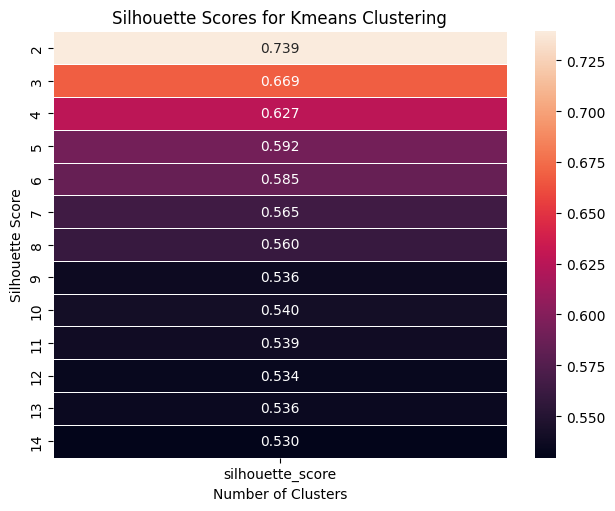

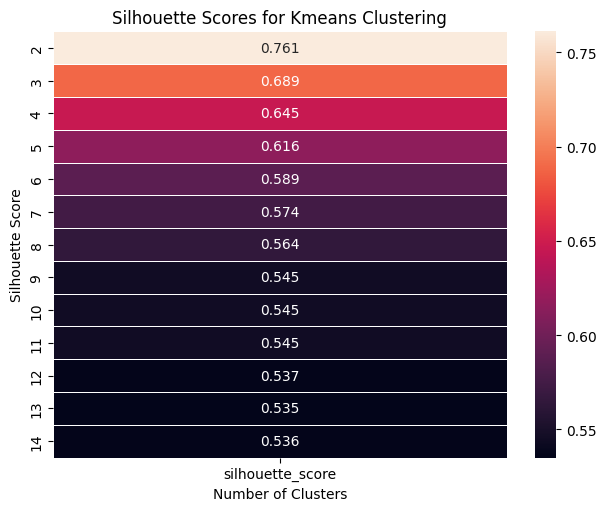

In [710]:
data_glm  = y_pred_glm.to_numpy().reshape(-1, 1)
data_cv  = y_pred_prob_class1.to_numpy().reshape(-1, 1)

visualize_silhouette_scores(data_glm, method='kmeans')
visualize_silhouette_scores(data_cv, method='kmeans')

K-Means Silhouette Score_glm : 0.63
K-Means Silhouette Score_cv : 0.65


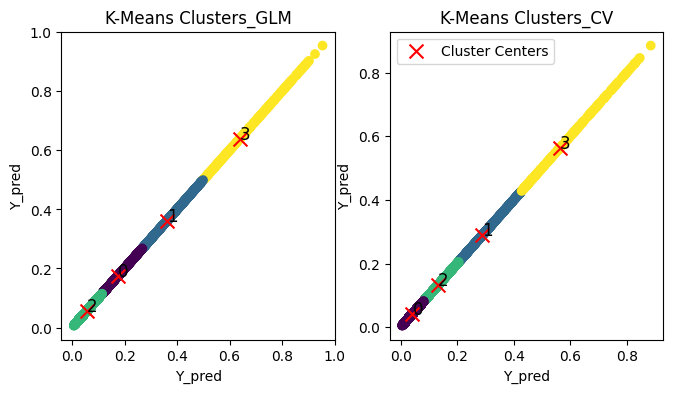

In [711]:
# GLM 
n_clusters = 4
X_glm = y_pred_glm.values.reshape(-1,1)
kmeans = KMeans(n_clusters=n_clusters)
kmeans_clusters_glm = kmeans.fit_predict(X_glm)
kmeans_silhouette_score_glm = silhouette_score(X_glm, kmeans_clusters_glm)
print(f"K-Means Silhouette Score_glm : {kmeans_silhouette_score_glm:.2f}")

# 데이터 시각화
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_glm, X_glm , c = kmeans_clusters_glm, cmap='viridis')
plt.scatter(kmeans.cluster_centers_, kmeans.cluster_centers_, c='red', marker='x', s=100, label='Cluster Centers')
plt.title('K-Means Clusters_GLM')
plt.xlabel('Y_pred')
plt.ylabel('Y_pred')
for i, cluster_num in enumerate(np.unique(kmeans_clusters_glm)):
    plt.text(kmeans.cluster_centers_[cluster_num, 0], kmeans.cluster_centers_[cluster_num, 0], str(cluster_num), color='black', fontsize=12)

# CV 모델 
X_cv = y_pred_prob_class1.values.reshape(-1,1)

kmeans = KMeans(n_clusters=n_clusters)
kmeans_clusters_cv = kmeans.fit_predict(X_cv)
kmeans_silhouette_score_cv = silhouette_score(X_cv, kmeans_clusters_cv)
print(f"K-Means Silhouette Score_cv : {kmeans_silhouette_score_cv:.2f}")

# 데이터 시각화
plt.subplot(132)
plt.scatter(X_cv, X_cv, c=kmeans_clusters_cv, cmap='viridis')
plt.scatter(kmeans.cluster_centers_, kmeans.cluster_centers_, c='red', marker='x', s=100, label='Cluster Centers')
plt.title('K-Means Clusters_CV')
plt.xlabel('Y_pred')
plt.ylabel('Y_pred')
for i, cluster_num in enumerate(np.unique(kmeans_clusters_cv)):
    plt.text(kmeans.cluster_centers_[cluster_num, 0], kmeans.cluster_centers_[cluster_num, 0], str(cluster_num), color='black', fontsize=12)

plt.legend()
plt.show()

In [712]:
# n_clusters = 4
# X_glm = y_pred_glm.values.reshape(-1,1)
# X_cv = y_pred_prob_class1.values.reshape(-1,1)

# kmeans = KMeans(n_clusters=n_clusters)
# kmeans_clusters_glm = kmeans.fit_predict(X_glm)
# kmeans_clusters_cv = kmeans.fit_predict(X_cv)

# kmeans_silhouette_score_glm = silhouette_score(X_glm, kmeans_clusters_glm)
# kmeans_silhouette_score_cv = silhouette_score(X_cv, kmeans_clusters_cv)

# print(f"K-Means Silhouette Score_glm : {kmeans_silhouette_score_glm:.2f}")
# print(f"K-Means Silhouette Score_cv : {kmeans_silhouette_score_cv:.2f}")

# agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
# agglomerative_clusters = agglomerative.fit_predict(X)
#agglomerative_silhouette_score = silhouette_score(X, agglomerative_clusters)
#print(f"Agglomerative Silhouette Score: {agglomerative_silhouette_score:.2f}")

# 데이터 시각화
#plt.figure(figsize=(12, 4))

# plt.subplot(131)
# plt.scatter(X, X , c=y_pred, cmap='viridis')
# plt.title('True Clusters')
# plt.xlabel('Y_pred')
# plt.ylabel('Y_pred')

# plt.subplot(131)
# plt.scatter(X_glm, X_glm , c = kmeans_clusters_glm, cmap='viridis')
# plt.scatter(kmeans.cluster_centers_, kmeans.cluster_centers_, c='red', marker='x', s=100, label='Cluster Centers')
# plt.title('K-Means Clusters_GLM')
# plt.xlabel('Y_pred')
# plt.ylabel('Y_pred')
# for i, cluster_num in enumerate(np.unique(kmeans_clusters_glm)):
#     plt.text(kmeans.cluster_centers_[cluster_num, 0], kmeans.cluster_centers_[cluster_num, 0], str(cluster_num), color='black', fontsize=12)
    
# plt.subplot(132)
# plt.scatter(X_cv, X_cv, c=kmeans_clusters_cv, cmap='viridis')
# plt.scatter(kmeans.cluster_centers_, kmeans.cluster_centers_, c='red', marker='x', s=100, label='Cluster Centers')
# plt.title('K-Means Clusters_CV')
# plt.xlabel('Y_pred')
# plt.ylabel('Y_pred')
# for i, cluster_num in enumerate(np.unique(kmeans_clusters_cv)):
#     plt.text(kmeans.cluster_centers_[cluster_num, 0], kmeans.cluster_centers_[cluster_num, 0], str(cluster_num), color='black', fontsize=12)

# plt.subplot(133)
# plt.scatter(X, X , c=agglomerative_clusters, cmap='viridis')
# plt.title('Agglomerative Clusters')
# plt.xlabel('Y_pred')
# plt.ylabel('Y_pred')
# for i, cluster_num in enumerate(np.unique(agglomerative_clusters)):
#     plt.text(y_pred[agglomerative_clusters == cluster_num].mean(), y_pred[agglomerative_clusters == cluster_num].mean(), str(cluster_num), color='black', fontsize=12)

# plt.legend()
# plt.show()


In [713]:
result_df = pd.DataFrame({'dlvry_id': test_set["dlvry_id"], '전체배차시간': test_set["전체배차시간"],
                          'outcome': test_set["outcome"], 'y_pred': y_pred_prob[:, 1].squeeze(),
                          'KMeansCluster': kmeans_clusters_cv}) #, 'AgglomerativeCluster': agglomerative_clusters_cv})

print(result_df.head())
result_df.to_csv('prj-ML-model-LT_OV30/cluster_add_data.csv', index= False, encoding = "utf-8")

                dlvry_id    전체배차시간  outcome    y_pred  KMeansCluster
25622  20230822_3561PFNZ  8.000000        1  0.080727              0
52745  20230825_4404SMBE  0.750000        0  0.043962              0
44564  20230823_0365XUHR  3.633333        0  0.087162              2
7455   20230901_5143VCEC  0.483333        0  0.059976              0
14651  20230903_0867KHNV  1.666667        0  0.036754              0


In [714]:
print(result_df['KMeansCluster'].value_counts())
#print(result_df['AgglomerativeCluster'].value_counts())

KMeansCluster
0    7385
2    2551
1     985
3     240
Name: count, dtype: int64


In [793]:
print(result_df.shape)

(11161, 5)


In [715]:
result_df.groupby('KMeansCluster')['전체배차시간'].agg(['mean', 'std', 'min', 'max'])

,mean,std,min,max
KMeansCluster,,,,
0,1.658016,2.682050,0.116667,41.550000
1,6.275059,7.692600,0.116667,44.416667
2,3.698687,5.521817,0.150000,57.400000
3,11.591528,10.171120,0.233333,50.783333


In [716]:
#result_df.groupby('AgglomerativeCluster')['전체배차시간'].agg(['mean', 'std', 'min', 'max'])

In [717]:
result_df.groupby('KMeansCluster')['y_pred'].agg(['mean', 'std', 'min', 'max'])

,mean,std,min,max
KMeansCluster,,,,
0,0.041603,0.019926,0.005007,0.086666
1,0.289136,0.059311,0.210432,0.424746
2,0.132179,0.033604,0.086684,0.210179
3,0.563026,0.114364,0.427132,0.884736


In [718]:
#result_df.groupby('AgglomerativeCluster')['y_pred'].agg(['mean', 'std', 'min', 'max'])

## 7. 최근 3일 서초구 배차건 대입

In [799]:
new_data = pd.read_csv("prj-ML-model-LT_OV30/new_data_final.csv", encoding="utf-8")


new_data.drop_duplicates(subset=['dlvry_id'], keep='first', inplace=True)
new_data = new_data.sort_values(by=["dlvry_id"])

ㅔ갸ㅜ

            dlvry_id business_day  reg_hour service_type   shop_no  ord_price  \
0  20230916_1540YBKT   2023-09-16        22          배민1  14150430      17500   
1  20230916_8028XRNQ   2023-09-16        16          배민1  14071109      14500   

   notiOver  actual_dlvry_distance  shop_loc_pnt_lat  shop_loc_pnt_lon  ...  \
0         0                    566         37.481687        126.992855  ...   
1         0                   3121         37.487130        126.983189  ...   

         dlvry_address  dlvry_지상층수  dlvry_지하층수  dlvry_건물용도  day_of_week  \
0  서울특별시 서초구 방배동 934-7         5.0         0.0        공동주택          Sat   
1   서울특별시 서초구 반포동 18-3         5.0         3.0        기타시설          Sat   

   is_holiday          일시    기온  강수량  시간  
0        True  2023-09-16  24.1  0.1  21  
1        True  2023-09-16  26.5  0.0  15  

[2 rows x 39 columns]


In [800]:
print(new_data.isna().sum())
print(new_data.shape) #18213

dlvry_id                    0
business_day                0
reg_hour                    0
service_type                0
shop_no                     0
ord_price                   0
notiOver                    0
actual_dlvry_distance       0
shop_loc_pnt_lat            0
shop_loc_pnt_lon            0
dlvry_loc_pnt_lat           0
dlvry_loc_pnt_lon           0
추천노출시간_AI                   0
추천노출시간_일반                   0
추천미발생시간유                    0
추천미발생시간무                    0
배차후취소시간                     0
전체배차시간                      0
notiOver_min_max            0
per_display                 0
per_no_recomm               0
pick_floor                  0
pick_rgn2_nm                0
pick_rgn3_nm                0
pick_category               0
pick_건물용도                   0
pick_address                0
Latitude                    0
Longitude                   0
dlvry_address               0
dlvry_지상층수               2310
dlvry_지하층수               2310
dlvry_건물용도                  0
day_of_wee

In [801]:
new_data[['dlvry_rgn1_nm', 'dlvry_rgn2_nm', 'dlvry_rgn3_nm', 'etc']] = new_data['dlvry_address'].str.split(' ', n=3, expand=True)

# dlvry_지하층수 음수로
new_data['dlvry_지하층수']  = new_data['dlvry_지하층수'].apply(lambda x: -x)
print(new_data.columns)

Index(['dlvry_id', 'business_day', 'reg_hour', 'service_type', 'shop_no',
       'ord_price', 'notiOver', 'actual_dlvry_distance', 'shop_loc_pnt_lat',
       'shop_loc_pnt_lon', 'dlvry_loc_pnt_lat', 'dlvry_loc_pnt_lon',
       '추천노출시간_AI', '추천노출시간_일반', '추천미발생시간유', '추천미발생시간무', '배차후취소시간', '전체배차시간',
       'notiOver_min_max', 'per_display', 'per_no_recomm', 'pick_floor',
       'pick_rgn2_nm', 'pick_rgn3_nm', 'pick_category', 'pick_건물용도',
       'pick_address', 'Latitude', 'Longitude', 'dlvry_address', 'dlvry_지상층수',
       'dlvry_지하층수', 'dlvry_건물용도', 'day_of_week', 'is_holiday', '일시', '기온',
       '강수량', '시간', 'dlvry_rgn1_nm', 'dlvry_rgn2_nm', 'dlvry_rgn3_nm', 'etc'],
      dtype='object')


## 7-1. pick_건물용도/dlvry_건물용도 : 개수 축소 

In [802]:
print(new_data['pick_건물용도'].value_counts())

pick_건물용도
업무시설          5783
근린생활시설        3277
일반음식점         2149
아파트           2138
일반상점          1676
공동주택          1241
교육시설           668
의료시설           497
백화점            183
자동차관련시설        160
오피스텔           107
숙박시설            75
기타시설            70
위락시설            56
대형판매점           49
문화시설            47
체육시설            19
종교시설            12
위험물저장및처리시설       5
운수시설             1
Name: count, dtype: int64


In [803]:
# 데이터 정리
values_to_replace = ['위락시설', '문화시설', '종교시설', '체육시설','위험물저장및처리시설', '자동차관련시설','운수시설']
new_data['pick_건물용도'] = new_data['pick_건물용도'].replace(values_to_replace, '기타시설')
print(new_data['pick_건물용도'].value_counts())

pick_건물용도
업무시설      5783
근린생활시설    3277
일반음식점     2149
아파트       2138
일반상점      1676
공동주택      1241
교육시설       668
의료시설       497
기타시설       370
백화점        183
오피스텔       107
숙박시설        75
대형판매점       49
Name: count, dtype: int64


In [804]:
print(new_data['dlvry_건물용도'].value_counts())

dlvry_건물용도
공동주택          7474
아파트           6006
업무시설          2323
근린생활시설         574
일반상점           504
교육시설           375
의료시설           232
일반음식점          217
숙박시설           211
공공시설            60
교육연구시설          53
종교시설            52
오피스텔            35
자동차관련시설         20
기타시설            14
방송통신시설          13
백화점             10
체육시설             9
위락시설             7
복지시설             6
위험물저장및처리시설       6
수련시설             3
운수시설             2
묘지시설             2
동식물시설            2
단독주택             1
복합몰              1
문화시설             1
Name: count, dtype: int64


In [805]:
new_counts = new_data['dlvry_건물용도'].value_counts()

threshold = 100
new_data['dlvry_건물용도'] = new_data['dlvry_건물용도'].apply(lambda x: '기타시설' if new_counts[x] <= threshold else x)

new_data['dlvry_건물용도'] = new_data['dlvry_건물용도'].replace('교육연구시설', '교육시설')
new_data['dlvry_건물용도'] = new_data['dlvry_건물용도'].replace('공공용시설', '공공시설')

print(new_data['dlvry_건물용도'].value_counts())

dlvry_건물용도
공동주택      7474
아파트       6006
업무시설      2323
근린생활시설     574
일반상점       504
교육시설       375
기타시설       297
의료시설       232
일반음식점      217
숙박시설       211
Name: count, dtype: int64


## 7-3. dlvry_지상층수/지하층수 : dlvry_건물용도별 median 값 가져오기

In [806]:
median_values =new_data.dropna().groupby('dlvry_건물용도')[['dlvry_지상층수', 'dlvry_지하층수']].median()
mean_values = new_data.dropna().groupby('dlvry_건물용도')[['dlvry_지상층수', 'dlvry_지하층수']].mean()

#print(median_values)
#print(mean_values)

# na 값을 중앙값으로 채우기
new_data['dlvry_지상층수'].fillna(new_data['dlvry_건물용도'].map(median_values['dlvry_지상층수']), inplace=True)
new_data['dlvry_지하층수'].fillna(new_data['dlvry_건물용도'].map(median_values['dlvry_지하층수']), inplace=True)

#print(new_data.describe())
print(new_data.isna().sum())

dlvry_id                 0
business_day             0
reg_hour                 0
service_type             0
shop_no                  0
ord_price                0
notiOver                 0
actual_dlvry_distance    0
shop_loc_pnt_lat         0
shop_loc_pnt_lon         0
dlvry_loc_pnt_lat        0
dlvry_loc_pnt_lon        0
추천노출시간_AI                0
추천노출시간_일반                0
추천미발생시간유                 0
추천미발생시간무                 0
배차후취소시간                  0
전체배차시간                   0
notiOver_min_max         0
per_display              0
per_no_recomm            0
pick_floor               0
pick_rgn2_nm             0
pick_rgn3_nm             0
pick_category            0
pick_건물용도                0
pick_address             0
Latitude                 0
Longitude                0
dlvry_address            0
dlvry_지상층수               0
dlvry_지하층수               0
dlvry_건물용도               0
day_of_week              0
is_holiday               0
일시                       0
기온                       0
강

In [807]:
new_data['pick_floor'] = new_data['pick_floor'].apply(categorize_floor)
new_data['dlvry_지상층수'] = new_data['dlvry_지상층수'].apply(categorize_floor)

print(new_data['dlvry_지상층수'].value_counts())
print(new_data['pick_floor'].value_counts())

dlvry_지상층수
저층      9328
중상층     3428
고층      2422
중층      2410
준초고층     573
초고층       52
Name: count, dtype: int64
pick_floor
저층    15333
지하     2840
중층       40
Name: count, dtype: int64


## 7-4. new_data 전처리

In [808]:
print(new_data.shape) #18,213
print(new_data.info()) 

(18213, 43)
<class 'pandas.core.frame.DataFrame'>
Index: 18213 entries, 11707 to 15878
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dlvry_id               18213 non-null  object 
 1   business_day           18213 non-null  object 
 2   reg_hour               18213 non-null  int64  
 3   service_type           18213 non-null  object 
 4   shop_no                18213 non-null  int64  
 5   ord_price              18213 non-null  int64  
 6   notiOver               18213 non-null  int64  
 7   actual_dlvry_distance  18213 non-null  int64  
 8   shop_loc_pnt_lat       18213 non-null  float64
 9   shop_loc_pnt_lon       18213 non-null  float64
 10  dlvry_loc_pnt_lat      18213 non-null  float64
 11  dlvry_loc_pnt_lon      18213 non-null  float64
 12  추천노출시간_AI              18213 non-null  float64
 13  추천노출시간_일반              18213 non-null  float64
 14  추천미발생시간유               18213 non-null  floa

In [809]:
new_model_df = new_data[['dlvry_id','reg_hour', 'ord_price','actual_dlvry_distance', 'pick_floor', 
                         'pick_category', 'pick_건물용도','dlvry_지상층수', 
                         'dlvry_건물용도','day_of_week', 'is_holiday', '기온'
                        ]]
new_model_df.isna().sum()


dlvry_id                 0
reg_hour                 0
ord_price                0
actual_dlvry_distance    0
pick_floor               0
pick_category            0
pick_건물용도                0
dlvry_지상층수               0
dlvry_건물용도               0
day_of_week              0
is_holiday               0
기온                       0
dtype: int64

In [810]:
print(new_model_df.shape)

(18213, 12)


## 7-5. factor 변수 encoding

In [811]:
# for col in ['reg_hour','pick_floor',  'pick_category', 'pick_건물용도','dlvry_지상층수','dlvry_건물용도',
#             'day_of_week', 'is_holiday','dlvry_rgn2_nm'] : 
#     new_model_df[col] = new_model_df[col].astype('category')

# print(new_model_df.dtypes)

In [812]:
var = ['is_holiday', 'pick_floor', 'reg_hour', 'pick_category', 'pick_건물용도', 'dlvry_지상층수', 'dlvry_건물용도']

new_model_df = pd.get_dummies(new_model_df, columns=var, prefix=var, drop_first=True)

for column in new_model_df .columns:
    for var_column in var:
        if var_column in column:
            new_model_df [column] = new_model_df [column].astype(int)

new_model_df  = new_model_df.sort_values(by=["dlvry_id"])

print(new_model_df .head(2))

# encoder = OneHotEncoder()
# onehot = pd.DataFrame(encoder.fit_transform(new_model_df[var]).toarray(), columns=encoder.get_feature_names_out(var), index = new_model_df.index)
# new_model_df = pd.concat([onehot, new_model_df.drop(columns=var)], axis=1)

# print(new_model_df.columns)

                dlvry_id  ord_price  actual_dlvry_distance day_of_week    기온  \
11707  20230915_0000JACM      27000                    144         Fri  21.8   
11693  20230915_0003QVZS      28000                   3994         Fri  23.4   

       pick_floor_중층  pick_floor_지하  reg_hour_10  reg_hour_11  reg_hour_12  \
11707              0              0            0            0            1   
11693              0              0            0            0            0   

       ...  dlvry_지상층수_초고층  dlvry_건물용도_교육시설  dlvry_건물용도_근린생활시설  \
11707  ...               0                0                  0   
11693  ...               0                0                  0   

       dlvry_건물용도_기타시설  dlvry_건물용도_숙박시설  dlvry_건물용도_아파트  dlvry_건물용도_업무시설  \
11707                0                0               0                1   
11693                0                0               0                0   

       dlvry_건물용도_의료시설  dlvry_건물용도_일반상점  dlvry_건물용도_일반음식점  
11707                0              

In [813]:
# numeric scale
new_model_df[num_vars] = scaler.transform(new_model_df[num_vars])
print(new_model_df.head(2))

                dlvry_id  ord_price  actual_dlvry_distance day_of_week  \
11707  20230915_0000JACM   0.046025               0.017877         Fri   
11693  20230915_0003QVZS   0.048117               0.499187         Fri   

             기온  pick_floor_중층  pick_floor_지하  reg_hour_10  reg_hour_11  \
11707  0.078740              0              0            0            0   
11693  0.204724              0              0            0            0   

       reg_hour_12  ...  dlvry_지상층수_초고층  dlvry_건물용도_교육시설  dlvry_건물용도_근린생활시설  \
11707            1  ...               0                0                  0   
11693            0  ...               0                0                  0   

       dlvry_건물용도_기타시설  dlvry_건물용도_숙박시설  dlvry_건물용도_아파트  dlvry_건물용도_업무시설  \
11707                0                0               0                1   
11693                0                0               0                0   

       dlvry_건물용도_의료시설  dlvry_건물용도_일반상점  dlvry_건물용도_일반음식점  
11707                0  

In [814]:
# 존재하지 않는 category 변수 추가 
new_variables = [col for col in X_train.columns if col not in new_model_df.columns]
encode_data = pd.DataFrame(0, columns=new_variables, index= new_model_df.index)
print(new_variables)

new_model_df = pd.concat([new_model_df, encode_data], axis=1)
new_model_df = new_model_df.reindex(columns=X_test.columns)
print(new_model_df.head())

['is_holiday_True', 'dlvry_건물용도_공동주택', 'dlvry_건물용도_오피스텔', 'dlvry_건물용도_종교시설']
       ord_price  actual_dlvry_distance        기온  is_holiday_True  \
11707   0.046025               0.017877  0.078740                0   
11693   0.048117               0.499187  0.204724                0   
10079   0.030335               0.236405  0.251969                0   
8645    0.052301               0.235404  0.031496                0   
8306    0.130753               0.163145  0.251969                0   

       pick_floor_중층  pick_floor_지하  reg_hour_10  reg_hour_11  reg_hour_12  \
11707              0              0            0            0            1   
11693              0              0            0            0            0   
10079              0              0            0            0            0   
8645               0              0            0            1            0   
8306               0              0            0            0            0   

       reg_hour_13  ...  dlvry_건물

## 7-6. modeling 적용

In [815]:
y_pred_new = model_cv.predict_proba(new_model_df)
print(y_pred_new.shape) #18,213 

(18213, 2)


In [816]:
print(pd.Series(y_pred_new[:, 1]).agg(['mean', 'std', 'min', 'max']))
print(y_pred_prob_class1.agg(['mean', 'std', 'min', 'max']))

mean    0.132451
std     0.134436
min     0.007802
max     0.970692
dtype: float64
mean    0.095364
std     0.106540
min     0.005007
max     0.884736
dtype: float64


In [817]:
print(new_data.shape) # 18,213
print(new_data.columns)

(18213, 43)
Index(['dlvry_id', 'business_day', 'reg_hour', 'service_type', 'shop_no',
       'ord_price', 'notiOver', 'actual_dlvry_distance', 'shop_loc_pnt_lat',
       'shop_loc_pnt_lon', 'dlvry_loc_pnt_lat', 'dlvry_loc_pnt_lon',
       '추천노출시간_AI', '추천노출시간_일반', '추천미발생시간유', '추천미발생시간무', '배차후취소시간', '전체배차시간',
       'notiOver_min_max', 'per_display', 'per_no_recomm', 'pick_floor',
       'pick_rgn2_nm', 'pick_rgn3_nm', 'pick_category', 'pick_건물용도',
       'pick_address', 'Latitude', 'Longitude', 'dlvry_address', 'dlvry_지상층수',
       'dlvry_지하층수', 'dlvry_건물용도', 'day_of_week', 'is_holiday', '일시', '기온',
       '강수량', '시간', 'dlvry_rgn1_nm', 'dlvry_rgn2_nm', 'dlvry_rgn3_nm', 'etc'],
      dtype='object')


In [818]:
#new_value = y_pred_new.to_numpy().reshape(-1,1)
new_value = y_pred_new[:, 1].reshape(-1,1)
kmeans_new = kmeans.predict(new_value)
#agglomerative_new = agglomerative.fit_predict(new_value)

result_data = pd.DataFrame({'dlvry_id': new_data["dlvry_id"],
                             'y_pred_new': y_pred_new[:, 1].squeeze(),
                            'KMeansCluster': kmeans_new #, 'AgglomerativeCluster': agglomerative_new
                            }) 
print(result_data.shape)


(18213, 3)


In [819]:
# join
result_data = result_data.merge(new_data, on = 'dlvry_id', how = 'left')
print(result_data.head(2))

result_data.to_csv('prj-ML-model-LT_OV30/cluster_add_new_data.csv', index= False, encoding = "utf-8")
result_data.to_excel('prj-ML-model-LT_OV30/cluster_add_new_data.xlsx', index=False)

            dlvry_id  y_pred_new  KMeansCluster business_day  reg_hour  \
0  20230915_0000JACM    0.015554              0   2023-09-15        12   
1  20230915_0003QVZS    0.547863              3   2023-09-15        21   

  service_type   shop_no  ord_price  notiOver  actual_dlvry_distance  ...  \
0          배민1  13490855      27000         0                    144  ...   
1          배민1  13512425      28000         0                   3994  ...   

   day_of_week  is_holiday          일시    기온  강수량  시간  dlvry_rgn1_nm  \
0          Fri        True  2023-09-15  21.8  0.0  11          서울특별시   
1          Fri        True  2023-09-15  23.4  0.0  20          서울특별시   

   dlvry_rgn2_nm  dlvry_rgn3_nm      etc  
0            서초구            서초동  1549-20  
1            서초구            서초동  1451-27  

[2 rows x 45 columns]


In [828]:
duplicates = new_data[new_data.duplicated(subset=['dlvry_id'], keep=False)]
print(duplicates)

                dlvry_id business_day  reg_hour service_type   shop_no  \
8044   20230915_3187LXAE   2023-09-15        16          배민1  13494863   
8043   20230915_3187LXAE   2023-09-15        16          배민1  13494863   
7097   20230915_8129TQPX   2023-09-15        12          배민1  13726330   
7096   20230915_8129TQPX   2023-09-15        12          배민1  13726330   
12187  20230917_7674ETQA   2023-09-17        17          배민1  13543243   
12188  20230917_7674ETQA   2023-09-17        17          배민1  13543243   
12258  20230917_9192MCDZ   2023-09-17        16          배민1  13862588   
12259  20230917_9192MCDZ   2023-09-17        16          배민1  13862588   

       ord_price  notiOver  actual_dlvry_distance  shop_loc_pnt_lat  \
8044       30000         0                   3599         37.479770   
8043       30000         0                   3599         37.479770   
7097       18600         0                   2016         37.494380   
7096       18600         0                   2016

In [826]:
print(result_data.shape)

(18221, 45)


In [820]:
print(result_data['KMeansCluster'].value_counts())
#print(result_data['AgglomerativeCluster'].value_counts())

KMeansCluster
0    9420
2    5462
1    2433
3     906
Name: count, dtype: int64


In [821]:
#result_data.groupby('AgglomerativeCluster')['y_pred_new'].agg(['mean', 'std', 'min', 'max'])

In [822]:
result_data.groupby('KMeansCluster')['y_pred_new'].agg(['mean', 'std', 'min', 'max'])

,mean,std,min,max
KMeansCluster,,,,
0,0.048217,0.019412,0.007802,0.086653
1,0.291203,0.058744,0.210331,0.425886
2,0.135356,0.035070,0.086686,0.210298
3,0.566508,0.116568,0.426008,0.970692


In [823]:
result_data.groupby('KMeansCluster')['전체배차시간'].agg(['mean', 'std', 'min', 'max'])

,mean,std,min,max
KMeansCluster,,,,
0,1.493937,2.685862,0.116667,36.650000
1,6.788697,8.741564,0.150000,58.900000
2,3.471235,5.606579,0.133333,57.233333
3,11.055169,11.085984,0.150000,72.100000


In [824]:
#result_data.groupby('AgglomerativeCluster')['전체배차시간'].agg(['mean', 'std', 'min', 'max'])

In [825]:
# 그룹별 전체배차시간 5.05분 이상인 애들 개수 
filtered_df = result_data[result_data['전체배차시간'] > 5.05]
grouped_counts = filtered_df.groupby('KMeansCluster').size()

print(grouped_counts)

KMeansCluster
0    488
1    919
2    997
3    520
dtype: int64
